In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

!pip install gdown
!gdown 'https://drive.google.com/uc?id=1rG_SrKgJ_PwdjKLH_xfsFPNlBG-6upXx'

!unzip 'for_unzipping.zip'
!mv for_unzipping/* ./
!rm -r for_unzipping
!rm for_unzipping.zip

Downloading...
From: https://drive.google.com/uc?id=1rG_SrKgJ_PwdjKLH_xfsFPNlBG-6upXx
To: /content/for_unzipping.zip
100% 3.80M/3.80M [00:00<00:00, 202MB/s]
Archive:  for_unzipping.zip
   creating: ATnT/
   creating: ATnT/s34/
  inflating: ATnT/s34/7.pgm          
  inflating: ATnT/s34/6.pgm          
  inflating: ATnT/s34/4.pgm          
  inflating: ATnT/s34/5.pgm          
  inflating: ATnT/s34/1.pgm          
  inflating: ATnT/s34/2.pgm          
  inflating: ATnT/s34/3.pgm          
  inflating: ATnT/s34/8.pgm          
  inflating: ATnT/s34/9.pgm          
  inflating: ATnT/s34/10.pgm         
   creating: ATnT/s33/
  inflating: ATnT/s33/7.pgm          
  inflating: ATnT/s33/6.pgm          
  inflating: ATnT/s33/4.pgm          
  inflating: ATnT/s33/5.pgm          
  inflating: ATnT/s33/1.pgm          
  inflating: ATnT/s33/2.pgm          
  inflating: ATnT/s33/3.pgm          
  inflating: ATnT/s33/8.pgm          
  inflating: ATnT/s33/9.pgm          
  inflating: ATnT/s33/10.pgm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

In [ ]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


In [ ]:
import numpy as np

def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguments:
    1. X (images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    # Compute the mean face
    mean_face = np.mean(X, axis=0)

    # Subtract the mean from each face
    X_normalized = X - mean_face

    # Compute the covariance matrix
    covariance_matrix = np.cov(X_normalized, rowvar=False)

    # Compute eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors based on eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select the first 'numComponents' eigenvectors as principal components
    principal_components = sorted_eigenvectors[:, :numComponents]

    return principal_components


# Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique commonly used in data analysis and computer vision. It's often used to identify patterns in data and to represent it in a more compact form.

## Explanation of PCA Steps :

### 1. Compute the mean face
Calculate the mean of all the faces in the dataset. This represents the average face across all the images.

### 2. Subtract the mean from each face
Normalize the dataset by subtracting the mean face from each individual face. This step centers the data around zero.

### 3. Compute the covariance matrix
Calculate the covariance matrix of the normalized data. The covariance matrix gives insights into how different features (pixels in this case) vary with respect to each other.

### 4. Compute eigenvectors and eigenvalues
Use a linear algebra library (in this case, numpy.linalg.eigh) to compute the eigenvectors and eigenvalues of the covariance matrix. Eigenvectors represent the directions of maximum variance, and eigenvalues represent the magnitude of variance along those directions.

### 5. Sort eigenvectors based on eigenvalues
Sort the eigenvectors in descending order based on their corresponding eigenvalues. This step ensures that the most significant principal components come first.

### 6. Select the first 'numComponents' eigenvectors
Choose the first 'numComponents' eigenvectors as the principal components. These are the directions in the feature space along which the data varies the most.

***The principal components obtained from PCA can be interpreted as the "eigenfaces" in this context, as they represent the main patterns or features present in the images.***


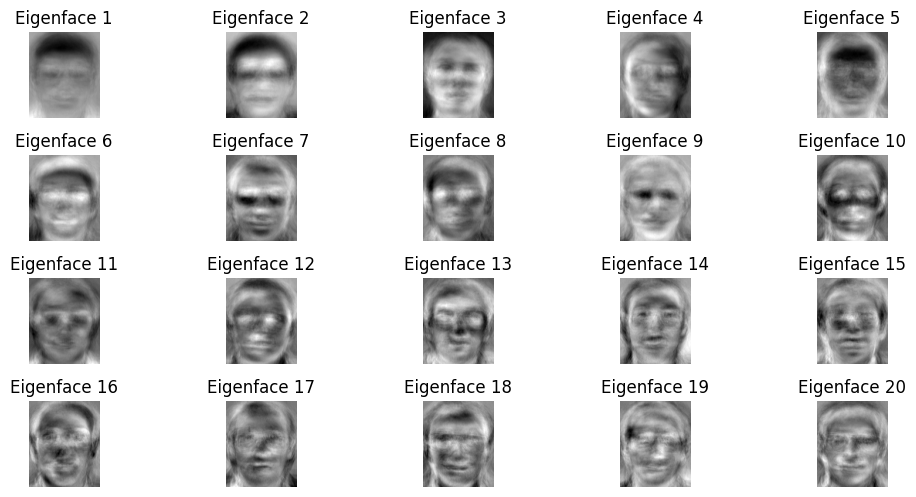

In [ ]:
import matplotlib.pyplot as plt

def plotEigenfaces(eigenFaces, numCols=5, numRows=8, figsize=(10, 10)):
    """
    Plot the eigenfaces
    """
    numComponents = eigenFaces.shape[1]
    numPlots = min(numComponents, numCols * numRows)

    plt.figure(figsize=figsize)
    for i in range(numPlots):
        plt.subplot(numRows, numCols, i+1)
        plt.imshow(eigenFaces[:, i].reshape(112, 92), cmap='gray')
        plt.title(f'Eigenface {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming you have already computed the eigenfaces using PCA
eigenFaces = principalComponentAnalysis(trainFaces.reshape((-1, 10304)), numComponents=20)  # Example with 20 components
plotEigenfaces(eigenFaces)


In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    # Flatten the test face
    testFace_flattened = testFace.flatten()

    # Compute the coefficients by projecting the test face onto the eigenfaces
    coefficients = np.dot(testFace_flattened - meanFace, eigenFaces)

    # Reconstruct the face by linearly combining the eigenfaces with the coefficients
    reconstructed_face_flattened = meanFace + np.dot(coefficients, eigenFaces.T)

    # Reshape the reconstructed face to its original dimensions
    reconstructed_face = np.reshape(reconstructed_face_flattened, testFace.shape)

    return reconstructed_face

# Image Reconstruction using PCA

This function imageReconstruction is a helper function used to reconstruct images using the principal components obtained from PCA.

## Explanation of Image Reconstruction Steps

1. **Flatten the test face**: Flatten the test face image into a 1-dimensional array. This step is necessary to perform matrix operations later.

2. **Compute the coefficients**: Project the flattened test face onto the eigenfaces. This is done by taking the dot product of the difference between the flattened test face and the mean face with the eigenfaces. These coefficients represent the contribution of each eigenface to the reconstruction of the test face.

3. **Reconstruct the face**: Reconstruct the face by linearly combining the eigenfaces with the coefficients. This is achieved by taking the dot product of the coefficients with the transpose of the eigenfaces matrix and then adding the mean face. This step generates a flattened reconstructed face.

4. **Reshape the reconstructed face**: Reshape the flattened reconstructed face back into the original dimensions of the test face.

***The function essentially utilizes the coefficients obtained from projecting the test face onto the eigenfaces to reconstruct the face in the original image space. This reconstructed face aims to approximate the original test face using a linear combination of the principal components (eigenfaces) and the mean face.***


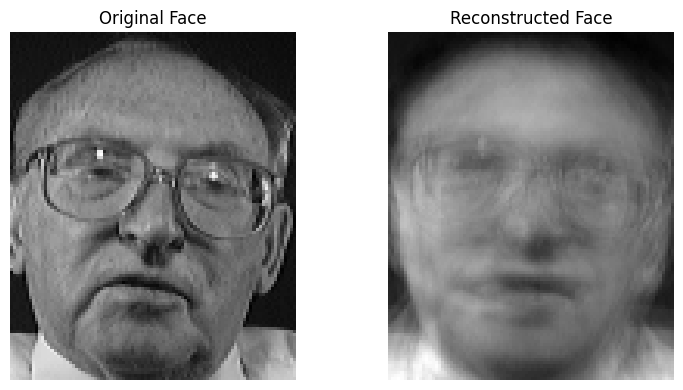

In [ ]:
import matplotlib.pyplot as plt

def plotComparison(original_face, reconstructed_face):
    """
    Plot original and reconstructed faces for comparison
    """
    plt.figure(figsize=(8, 4))

    # Plot original face
    plt.subplot(1, 2, 1)
    plt.imshow(original_face, cmap='gray')
    plt.title('Original Face')
    plt.axis('off')

    # Plot reconstructed face
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('Reconstructed Face')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Compute the mean face
mean_face = np.mean(trainFaces, axis=0)

# Select a test face (for example, the first test face)
test_face = testFaces[0]

# Reconstruct the test face using eigenfaces and the mean face
reconstructed_face = imageReconstruction(test_face.flatten(), eigenFaces, mean_face.flatten())

# Reshape the reconstructed face to its original dimensions
reconstructed_face = np.reshape(reconstructed_face, test_face.shape)

# Plot original and reconstructed faces
plotComparison(test_face, reconstructed_face)


Reconstruction with 5 Factors


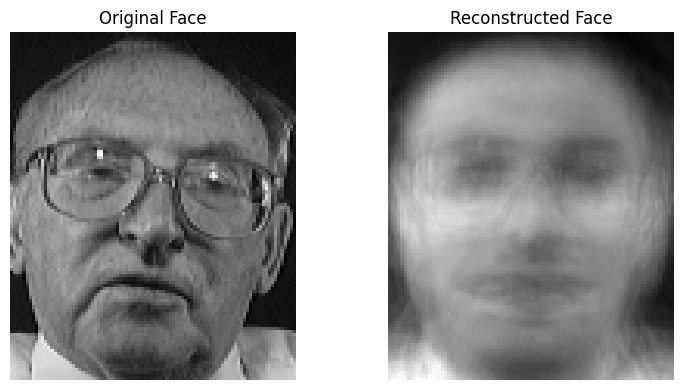

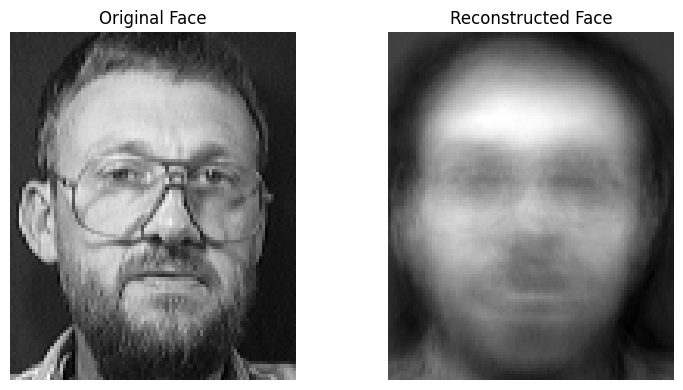

<Figure size 640x480 with 0 Axes>

Reconstruction with 10 Factors


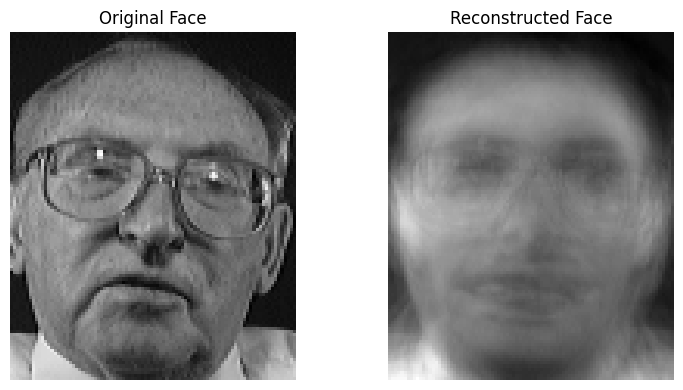

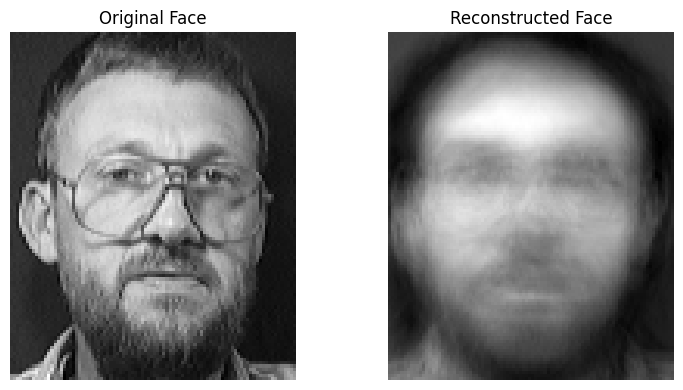

<Figure size 640x480 with 0 Axes>

Reconstruction with 50 Factors


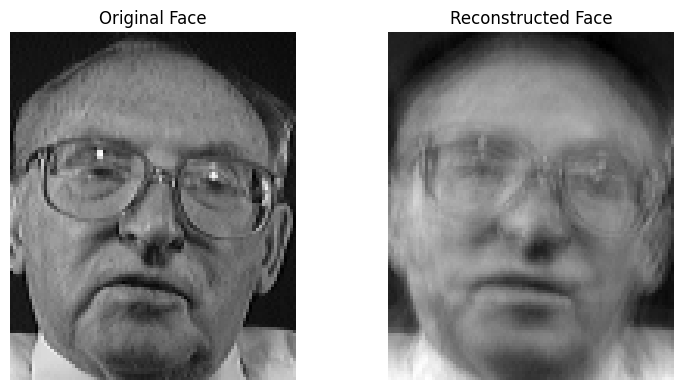

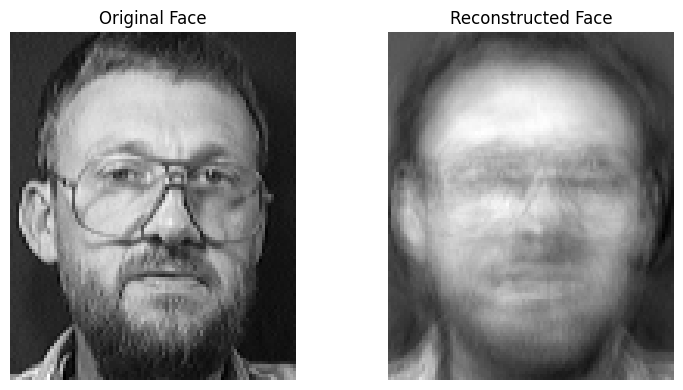

<Figure size 640x480 with 0 Axes>

Reconstruction with 100 Factors


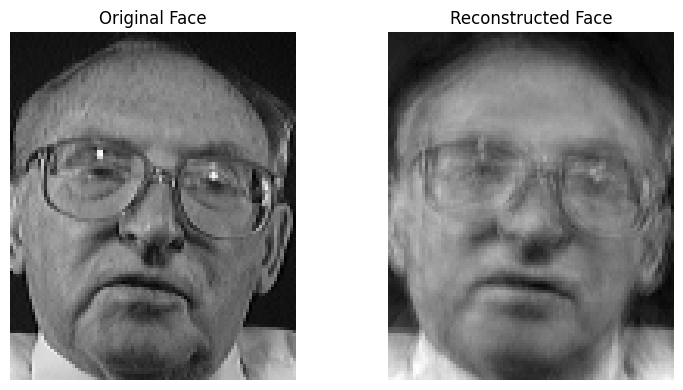

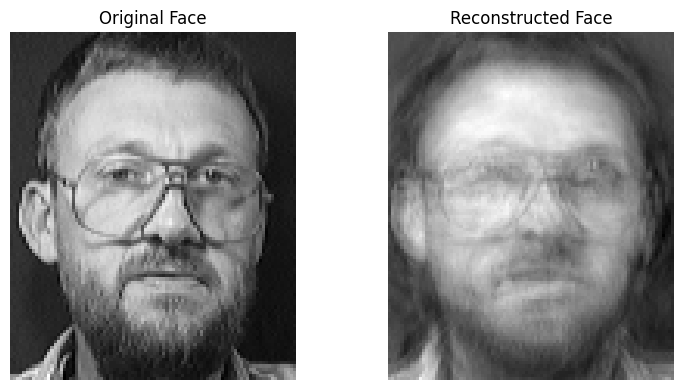

<Figure size 640x480 with 0 Axes>

Reconstruction with 200 Factors


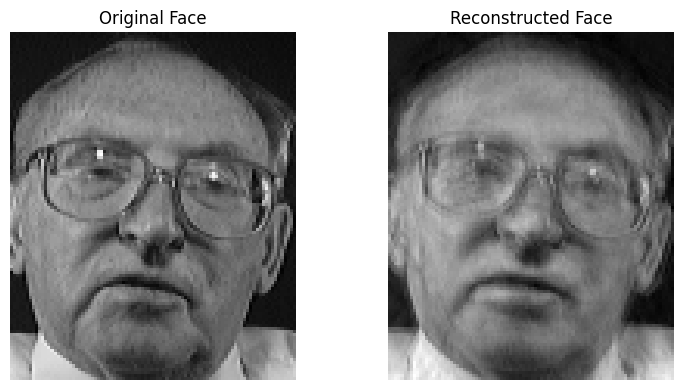

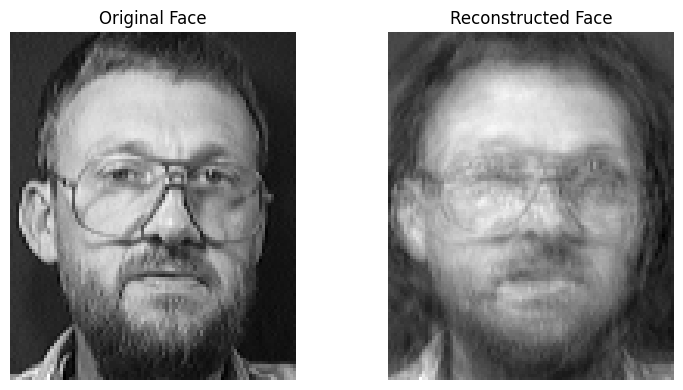

<Figure size 640x480 with 0 Axes>

Reconstruction with 400 Factors


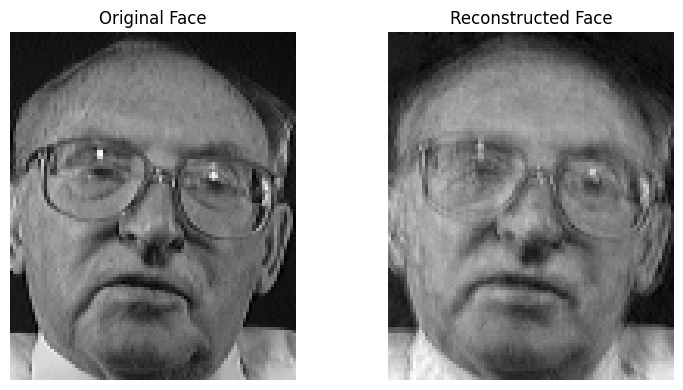

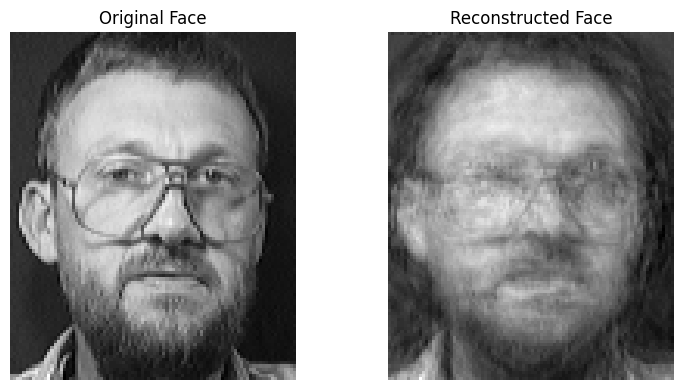

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def displayNfactors(testFaces, numFactorsList, trainFaces, trainLabels):
    """
    Visualize the results for different numbers of factors (principal components)
    """
    numTestFaces = testFaces.shape[0]

    for numFactors in numFactorsList:
        # Compute eigenfaces using PCA with the current number of factors
        eigenFaces = principalComponentAnalysis(trainFaces.reshape((-1, 10304)), numComponents=numFactors)

        # plt.figure(figsize=(15, 3))
        # plt.suptitle(f'Reconstruction with {numFactors} Factors', fontsize=16)
        print(f'Reconstruction with {numFactors} Factors')

        for i in range(2):
            test_face = testFaces[i]

            # Reconstruct the test face using eigenfaces and the mean face
            reconstructed_face = imageReconstruction(test_face.flatten(), eigenFaces, np.mean(trainFaces, axis=0).flatten())

            # Reshape the reconstructed face to its original dimensions
            reconstructed_face = np.reshape(reconstructed_face, test_face.shape)

            plotComparison(test_face, reconstructed_face)

        plt.tight_layout()
        plt.show()


# Example usage:
numFactorsList = [5, 10, 50, 100, 200, 400]
displayNfactors(testFaces, numFactorsList, trainFaces, trainLabels)


In [ ]:
def getClass(test_image, eigenfaces, mean_eigen_face, X_train, y_train):
    """
    Arguments:
    1. test_image: Test image
    2. eigenfaces: Eigenvectors
    3. mean_eigen_face: Mean Eigen Face
    4. X_train: Training Set images
    5. y_train: Training Set labels

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """
    min_error = float('inf')
    best_match = None
    prediction = None

    # Compute coefficients for the test image
    test_coefficients = np.dot((test_image.flatten() - mean_eigen_face.flatten()), eigenfaces)

    for i in range(len(X_train)):
        train_image = X_train[i]

        # Reconstruct the train image using eigenfaces and the mean face
        reconstructed_image = mean_eigen_face.flatten() + np.dot(test_coefficients, eigenfaces.T)

        # Calculate the mean squared error (MSE)
        error = np.mean((train_image.flatten() - reconstructed_image) ** 2)

        # Check if current error is smaller than the minimum error
        if error < min_error:
            min_error = error
            best_match = train_image
            prediction = y_train[i]

    return best_match, min_error, prediction

# Class Prediction using Eigenfaces

This function, `getClass`, is used to classify a test image by finding the closest match in a training set using the eigenfaces obtained from PCA.

## Explanation of the Steps:

1. **Initialize variables**: Initialize `min_error` as positive infinity, `best_match` as None, and `prediction` as None. These variables will be used to track the image with the smallest error, the error value, and the predicted class, respectively.

2. **Compute coefficients for the test image**: Project the flattened test image onto the eigenfaces to obtain the coefficients representing its contribution along each principal component.

3. **Iterate through training images**: Loop through each image in the training set.

4. **Reconstruct the training image**: Reconstruct the current training image using the computed eigenfaces and the mean eigen face. This is done by applying the coefficients obtained from the test image to the eigenfaces and adding the mean eigen face.

5. **Calculate mean squared error (MSE)**: Compute the mean squared error between the reconstructed image and the current training image. This measures the similarity between the two images.

6. **Update minimum error and best match**: If the current error is smaller than the minimum error encountered so far, update the minimum error, the best matching image, and the predicted class.

7. **Return results**: Return the image with the smallest error (`best_match`), the error value (`min_error`), and the predicted class (`prediction`).

***The function essentially compares the test image with each image in the training set by reconstructing each training image using the eigenfaces. The image with the smallest reconstruction error is considered the best match, and its corresponding class is predicted as the label for the test image.***


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def testAccuracy(testFaces, testLabels, mean_eigen_face, X_train, y_train, components):
    """
    Test the accuracy by taking different number of components
    """
    accuracies = []
    mse = []

    for numComponents in components:
        # Compute eigenfaces using PCA with the current number of components
        eigenfaces = principalComponentAnalysis(X_train.reshape((-1, 10304)), numComponents=numComponents)

        total_error = 0
        correct_predictions = 0

        # Test each image in the test set
        for i in range(len(testFaces)):
            test_image = testFaces[i]
            true_label = testLabels[i]

            # Get the closest match and its error
            best_match, error, prediction = getClass(test_image, eigenfaces, mean_eigen_face, X_train, y_train)

            total_error += error

            # Check if prediction is correct
            if prediction == true_label:
                correct_predictions += 1

        # Calculate mean square error and accuracy
        mean_error = total_error / len(testFaces)
        accuracy = correct_predictions / len(testFaces)

        # Append mean square error and accuracy to lists
        mse.append(mean_error)
        accuracies.append(accuracy)

        print('Components = ',numComponents)
        print('MSE = ',mean_error)
        print('Accuracy = ',accuracy)
        print('')

    return mse, accuracies

# Define the list of components
components = [3, 5, 10, 20, 30, 40, 50, 100, 200]

# Test accuracy and compute MSE for each number of components
mse, accuracies = testAccuracy(testFaces, testLabels, np.mean(trainFaces, axis=0), trainFaces, trainLabels, components)



Components =  3
MSE =  766.6726456678554
Accuracy =  0.2

Components =  5
MSE =  810.5735810180379
Accuracy =  0.3

Components =  10
MSE =  760.785402079927
Accuracy =  0.75

Components =  20
MSE =  680.5271144633668
Accuracy =  0.9

Components =  30
MSE =  638.1524734545087
Accuracy =  0.95

Components =  40
MSE =  616.5497030024336
Accuracy =  0.95

Components =  50
MSE =  601.5997509585721
Accuracy =  0.95

Components =  100
MSE =  583.5580163378506
Accuracy =  0.95

Components =  200
MSE =  585.1036482752559
Accuracy =  0.95



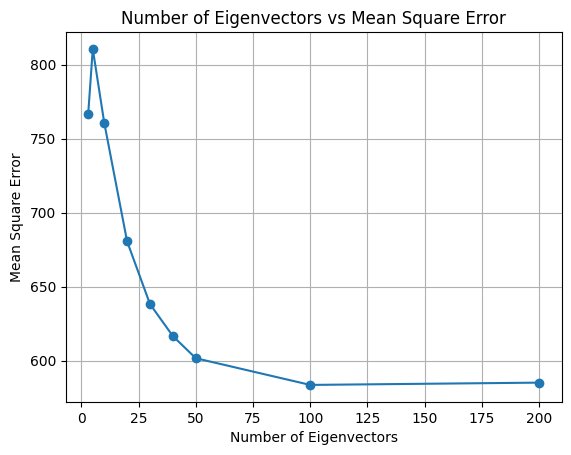

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotError(components, mse, title):
    """
    Plot Number of eigenvectors vs Mean Square Error
    """
    plt.plot(components, mse, marker='o')
    plt.title(title)
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Mean Square Error')
    plt.grid(True)
    plt.show()

plotError(components, mse, 'Number of Eigenvectors vs Mean Square Error')

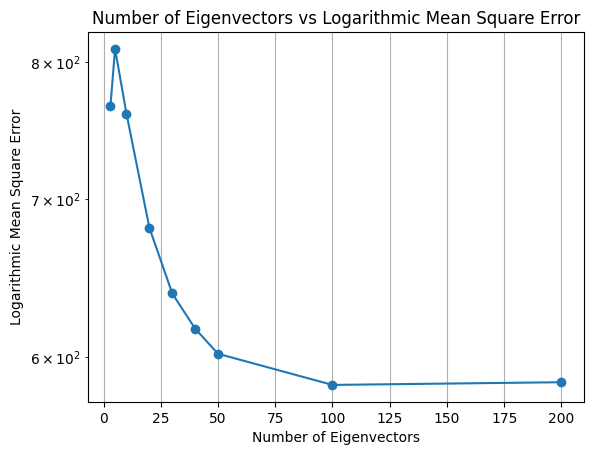

In [ ]:
def plotLogError(components, mse, title):
    """
    Plot Number of eigenvectors vs Logarithmic Mean Square Error
    """
    plt.semilogy(components, mse, marker='o')
    plt.title(title)
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Logarithmic Mean Square Error')
    plt.grid(True)
    plt.show()

plotLogError(components, mse, 'Number of Eigenvectors vs Logarithmic Mean Square Error')

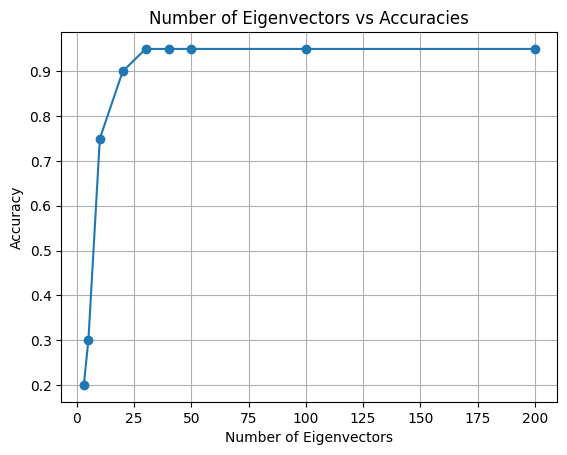

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotError(components, mse, title):
    """
    Plot Number of eigenvectors vs Accuracy
    """
    plt.plot(components, mse, marker='o')
    plt.title(title)
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

plotError(components, accuracies, 'Number of Eigenvectors vs Accuracies')